In [1]:
import plotly.express as px
from load_data import load_df, load_tags, load_and_create_ground_truth_df
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter

### Création d'un dataframe avec les données disponibles

In [2]:
data = load_df('../data/entities.json')
input_tokens = load_tags('../data/tokens.yml')
df = load_and_create_ground_truth_df(data, input_tokens)

#### Statistiques descriptives

In [3]:
df.head()

,age,birth_date,civil_status,education_level,employer,firstname,link,lob,maiden_name,nationality,observation,occupation,surname,surname_household
0,25,None,Garçon,None,None,Cyrille,None,None,None,française,None,menuisier,Breton,None
1,30,None,Garçon,None,None,Auguste,None,None,None,Piémontaise,None,vitrier,None,Ferazzi
2,24,None,Garçon,None,None,Pierre,None,None,None,Piémontaise,None,vitrier,None,Machol
3,48,None,Homme marié,None,None,Alexandre,None,None,None,française,None,prop re,None,Desbois
4,30,None,None,None,None,Zélie,sa fe,None,None,française,None,prop re,Vignat,None


In [4]:
# Drop rows with only NaN values
df = df.dropna(how='all')

# 25075 rows (=persons), 14 columns (=categories)
df.shape

(25075, 14)

In [5]:
df.describe()

,age,birth_date,civil_status,education_level,employer,firstname,link,lob,maiden_name,nationality,observation,occupation,surname,surname_household
count,16436,7344,10705,0,2911,24931,20736,9236,0,13314,602,16179,19159,5640
unique,253,158,6,0,1087,2456,937,2923,0,73,310,2056,8120,4126
top,2,1901,Garçon,NaN,patron,Marie,chef,idem,NaN,française,idem,idem,idem,Martin
freq,337,138,2824,NaN,644,2758,3022,3378,NaN,7916,88,3695,669,29


In [6]:
# Missing values
missing_percentage = df.isnull().sum() / len(df) * 100
missing_percentage = missing_percentage.reset_index()
missing_percentage.columns = ['Column', 'MissingPercentage']
missing_percentage = missing_percentage.sort_values(by='MissingPercentage', ascending=False)

# Plot
fig = px.bar(missing_percentage, x='Column', y='MissingPercentage', text='MissingPercentage',
             title="Pourcentage de valeurs manquantes par catégorie",
             width=700,
             height=500)
fig.update_traces(texttemplate='%{text:.1f}%', textposition='outside', textfont_size=15)
fig.update_layout(yaxis=dict(title='Pourcentage de valeurs manquantes'),
                  xaxis=dict(title='Catégorie'),
                  font = dict(size=14))
fig.show()

In [7]:
# Duplicates
# df[df.duplicated()]
# df[(df.duplicated()) & (df['firstname']=='Marie')].shape
df.duplicated().sum()

41

In [8]:
# Unique values
unique_values_count = df.nunique()
unique_values_count = unique_values_count.reset_index()
unique_values_count.columns = ['Column', 'UniqueValuesCount']

# Sort the DataFrame by the UniqueValuesCount column
unique_values_count_sorted = unique_values_count.sort_values(by='UniqueValuesCount', ascending=False)

# Plot with the sorted data
fig = px.bar(unique_values_count_sorted, x='Column', y='UniqueValuesCount', text='UniqueValuesCount',
             title="Nombre de valeurs uniques par catégorie",
             width=700, height=500)
fig.update_traces(texttemplate='%{text}', textposition='outside', textfont_size=13)
fig.update_layout(yaxis=dict(title='Nombre de valeurs uniques'),
                  xaxis=dict(title='Catégorie'),
                  font = dict(size=14))
fig.show()

In [9]:
# Count number of different surnames, including surname_household
unique_surnames = set(df['surname_household']).union(set(df['surname']))
num_unique_surnames = len(unique_surnames)
print("Number of different surnames:", num_unique_surnames)

Number of different surnames: 9589


In [10]:
print(f"Civil status: {df['civil_status'].unique()}")
print(f"Civil status when surname_household is not null:")
df[df['surname_household'].notnull()]['civil_status'].value_counts()

# Plot histogram
fig = px.histogram(df, x='civil_status', 
                   title='Histogramme de la variable civil_status', 
                   width=700, height=500)
fig.update_layout(yaxis=dict(title='Count'),
                  xaxis=dict(title='Statut civil'),
                  font = dict(size=14))
fig.show()

Civil status: ['Garçon' 'Homme marié' None 'Fille' 'Femme mariée' 'Veuve' 'Veuf']
Civil status when surname_household is not null:


In [11]:
# Prénoms les plus observés
top_names = df['firstname'].value_counts().head(10)
top_names_df = top_names.reset_index()
top_names_df.columns = ['Prénom', 'Nombre de fois donné']

fig = px.bar(top_names_df, x='Prénom', y='Nombre de fois donné',
            #  title='Les 10 prénoms les plus courants',
             labels={'Prénom': 'Prénom', 'Nombre de fois donné': 'Nombre de fois donné'},
             width=700,
             height=500)
fig.update_layout(xaxis_tickangle=-45,
                #   plot_bgcolor='white',
                  xaxis=dict(title='Prénom'),
                  yaxis=dict(title='Nombre de fois donné'),
                  title=dict(x=0.5),
                  font = dict(size=14))
fig.show()

In [12]:
# Âge
df_age = df.copy()
df_age = df_age[df_age['age'].apply(lambda x: len(str(x)) != 4)]
df_age = df_age[df_age['age'].apply(lambda x: len(str(x)) != 3)]
df_age = df_age[~df_age['age'].str.contains('\⁇')]
df_age = df_age[~df_age['age'].str.contains('\?')]
df_age = df_age.replace(to_replace='mois', value=1, regex=True)
df_age = df_age.replace(to_replace='mpis', value=1, regex=True)
df_age = df_age.replace(to_replace='semaines', value=1, regex=True)
df_age = df_age.replace(to_replace='jours', value=0, regex=True)
df_age = df_age.replace(to_replace='jour', value=0, regex=True)
df_age['age'] = df_age['age'].str.replace(' ans', '')
df_age['age'] = df_age['age'].str.replace('ans', '')
df_age['age'] = df_age['age'].str.replace('an', '')
df_age['age'] = df_age['age'].str.replace("1'", '1')

df_age = df_age[df_age['age'].apply(lambda x: len(str(x)) < 3)]
df_age['age'] = df_age['age'].astype(int)
print(f"Age moyen : {df_age['age'].mean()}")
print(f"Age médian : {df_age['age'].median()}")
# print(set(df_age['age'].unique()))

Age moyen : 31.55021181161226
Age médian : 29.0


In [13]:
# Année de naissance
df_birth_year = df.copy()
df_birth_year = df_birth_year[df_birth_year['birth_date'].apply(lambda x: len(str(x)) == 4)]
df_birth_year = df_birth_year[df_birth_year['birth_date']!='idem']
df_birth_year = df_birth_year.dropna(subset=['birth_date'])

df_birth_year['birth_date'] = df_birth_year['birth_date'].astype(int)
px.histogram(df_birth_year, x='birth_date', 
            #  title='Histogramme des années de naissance',
             nbins=50, 
             width=800, 
             height=500)



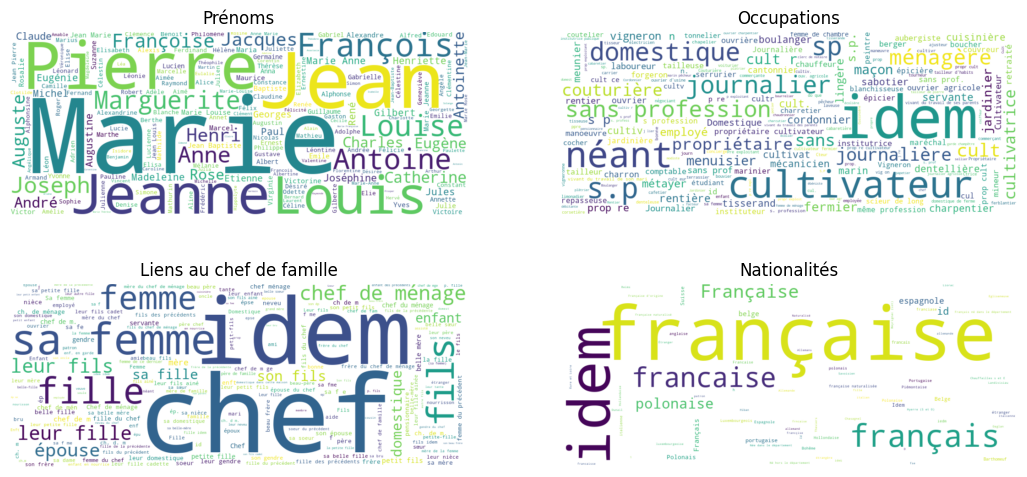

In [14]:
# Word clouds
fig, ax = plt.subplots(2, 2, figsize=(13, 6))
wordcloud1 = WordCloud(width=1000, height=400, background_color='white').generate_from_frequencies(Counter(df.firstname.dropna().astype(str).tolist()))
ax[0][0].imshow(wordcloud1, interpolation='bilinear')
ax[0][0].axis('off')
ax[0][0].set_title('Prénoms')
wordcloud2 = WordCloud(width=1000, height=400, background_color='white').generate_from_frequencies(Counter(df.occupation.dropna().astype(str).tolist()))
ax[0][1].imshow(wordcloud2, interpolation='bilinear')
ax[0][1].axis('off')
ax[0][1].set_title('Occupations')
wordcloud3 = WordCloud(width=1000, height=400, background_color='white').generate_from_frequencies(Counter(df.link.dropna().astype(str).tolist()))
ax[1][0].imshow(wordcloud3, interpolation='bilinear')
ax[1][0].axis('off')
ax[1][0].set_title('Liens au chef de famille')
wordcloud4 = WordCloud(width=1000, height=400, background_color='white').generate_from_frequencies(Counter(df.nationality.dropna().astype(str).tolist()))
ax[1][1].imshow(wordcloud4, interpolation='bilinear')
ax[1][1].axis('off')
ax[1][1].set_title('Nationalités')
plt.show() 